# Graph Neural Network

- 분자의 표현형으로 그래프를 표현하고
- 분자의 동작을 그래프 컨볼류션 네트워크로 모델링 하는 방법
- [강의자료](https://github.com/StillWork/image/blob/main/AIDD-LAIDD-2022.pdf)


## 분자의 그래프 표현

- 분자의 표현형을 학습시키는데 그래프를 사용하는 방법 소개

- 딥러닝 기술이 발전하면서, 고정된 분자 표현형을 사용하는 것이 아니라 표현형을 학습하는 것이 가능하게 되었다
- 영상처리나 자연어 처리와 같이 비정형 데이터를 분석하는 데 신경망이 유효한 것처럼 비정형의 분자 정보를 다루는 것이 가능해졌다
- SMILES를 자연어처럼 시퀀스로 볼 수 있다
 - 다량의 화합물 데이터로 비지도 학습을 하고, 즉 SMILES를 읽는 법을 배우고 이후에 적은 수의 레이블 데이터를 가지고 예측 등 지도학습을 수행한다(fine tuning)
- 그래프로 표현
 - SMILES 보다 분자 표현에 더 적합 (원자와 결합을 표시)
 - message passing을 반복 수행하면 각 노드를 연속형 값을 갖는 벡터로 표현하게 된다
 - graph convolution 등을 만들어 분자 특성을 예측하는 성능을 높였다
 - end-to-end 학습을 수행하여 기존의 전통적인 표현형의 성능을 개선했다

## sequences 와 graph 표현

- SMILES를 자연어처럼 시퀀스로 볼 때, RNN을 이용하여 sequences 형태로 처리하는 것과 graph 표현형을 사용하는 두 가지 방법이 가능하다

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-11-22%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%205.56.01.png?raw=1" align='left'>

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-11-22%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%205.56.14.png?raw=1" align='left'>

- 분자의 그래프 표현형을 사용하겠다

 - 각 원자를 나타내는 feature 벡터가 있고 이들로부터 구성된 feature matrix를 정의한다
 - 각 원자들의 연결 정보를 나타내는 adjacency matrix를 정의한다

<img src="https://github.com/StillWork/image/blob/main/Representation-of-a-molecule-as-a-multi-channel-multi-attribute-graph-The-molecule.png?raw=1" align='left'  width=300>

## Graph Convolutions 개념

- 일반 CNN
 - 이미지나 시계열의 패턴 분석에 널리 사용된다
 - 신호가 주변의 샘플들과 같이 필터를 통과하면서 어떤 추상적인 패턴을 추출한다
 - 컨볼류션 계층을 여러번 통과하면서 점차 추상적인 패턴을 찾는다 
 - 풀링(max pooling)을 수행하여 패턴신호(특성)의 공간적인 이동과 정보 축약을 수행한다
 - [CNN 개요](https://medium.com/@ricardo_fideles/dog-breed-classification-with-cnn-827963a67bdf), [이미지 필터링](https://setosa.io/ev/image-kernels/), [CNN 동작 설명](https://transcranial.github.io/keras-js/#/mnist-cnn)

- 그래프 컨볼류션
 - 일반 CNN과 유사하나 이미지나 시계열 데이터가 아니라 그래프로 표현된 입력을 대상으로 동작한다
 - 주변 샘플 전체가 아니라 그래프로 연결된 샘플들만 사용하여 컨볼류션과 풀링을 수행한다
 - [Distill GCN](https://distill.pub/2021/gnn-intro/)
 - [블로그](https://ai.plainenglish.io/graph-convolutional-networks-gcn-baf337d5cb6b)


# import

In [1]:
!pip install deepchem
import deepchem as dc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit import DataStructs
import tensorflow as tf

from deepchem.feat.mol_graphs import ConvMol
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
from deepchem.models.graph_models import GraphConvModel

from deepchem.metrics import to_one_hot
from deepchem.utils.data_utils import load_from_disk
import tensorflow.keras.layers as layers

# 회귀 모델

- 용해도 예측
 - 물질이 용매에 포화상태까지 녹을 수 있는 한도
 - 분자 구조 정보로부터 용해도(y)를 예측
 - 알려진 실제 화합물의 용해도로부터,유사한 화합물의 용해도를 예측하는 데 사용

In [ ]:
from deepchem.utils.data_utils import load_from_disk

# 데이터 다운로드
logP_data = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/logP_dataset.csv', names=['smiles', 'logP'])
print(logP_data.shape)

# csv 파일로 저장
logP_data.to_csv('logP.csv')

# 디스크에서 파일 지정
dataset_file = load_from_disk('logP.csv')

# 표현형 (특성)을 그래프 표현형인 ConvMol로 선택
featurizer = dc.feat.ConvMolFeaturizer()

# loader로 CSVLoader를 사용하면서 X, y, 표현형 등을 정의
loader = dc.data.CSVLoader(tasks=["logP"], feature_field="smiles",featurizer=featurizer)
dataset = loader.featurize(dataset_file)

In [ ]:
# Scaffold Splitter 지정
splitter = dc.splits.ScaffoldSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

# 랜덤 splitter를 사용하는 경우
# splitter = dc.splits.RandomSplitter()

# 표준 스케일링을 적용
transformers = [dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

from deepchem.models.graph_models import GraphConvModel
model = GraphConvModel(n_tasks=1, mode='regression', batch_size=50, 
                       model_dir="./models/logD", random_seed=0)

## 모델 학습

In [ ]:
model.fit(train_dataset, nb_epoch=100, deterministic=True)

R2: 0.9564
MAE: 0.1928
RMSE: 0.2678
Max error: 2.6703


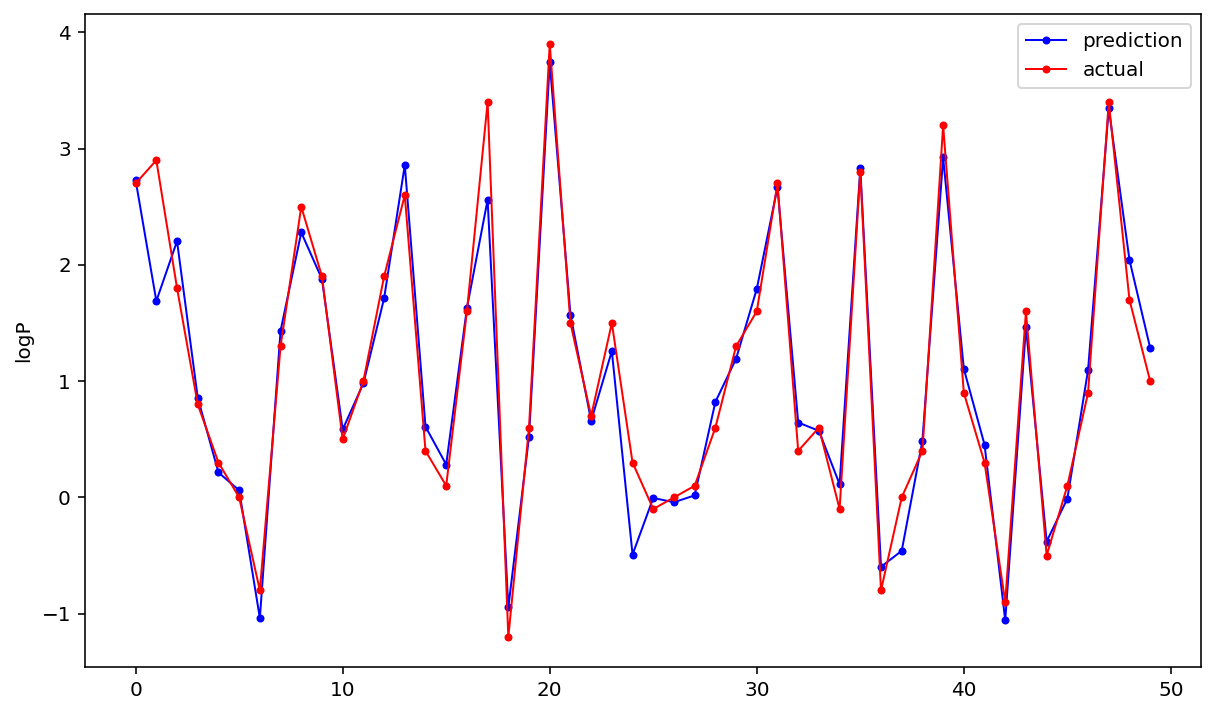

In [ ]:
y_pred = model.predict(test_dataset)
show_reg_result(test_dataset.y, y_pred)

In [ ]:
solubilities = dc_gcn.predict_on_batch(test_dataset.X)
for molecule, solubility, test_solubility in zip(test_dataset.ids, solubilities, test_dataset.y):
    print(solubility, test_solubility, molecule)

## 모델 적용
- 임의의 샘플에 적용해보기

In [ ]:
smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
          'CCOC(=O)CC',
          'CSc1nc(NC(C)C)nc(NC(C)C)n1',
          'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
          'Cc1cc2ccccc2cc1C']
mols = [Chem.MolFromSmiles(s) for s in smiles]
featurizer = dc.feat.ConvMolFeaturizer()
x = featurizer.featurize(mols)
predicted_solubility = dc_gcn.predict_on_batch(x)
for m,s in zip(smiles, predicted_solubility):
    print()
    print('Molecule:', m)
    print('Predicted solubility:', s)

# ConvMol  소개
- 분자의 그래프 표현형

In [ ]:
x[1]

In [ ]:
# 두번째 분자 보기
mol = Chem.MolFromSmiles("CCOC(=O)CC")
# for atom in mol.GetAtoms():
#   atom.SetAtomMapNum(atom.GetIdx())
mol

In [ ]:
# ConvMol 특성의 구조 (원자가 7이고, 특성 벡터수가 75임)
x[1].atom_features.shape

In [ ]:
x[1].get_atom_features()

In [ ]:
# 7개 원자의 인접 노드 번호들 보기
x[1].get_adjacency_list()

# 분류 모델

- tox21 데이터 사용
- featurizer='GraphConv' 적용

In [23]:
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

## 모델 정의, 학습, 평가
- GraphConvModel 모델 사용
- 기본 모델 구조를 사용한다

In [24]:
n_tasks = len(tasks)
model = dc.models.GraphConvModel(n_tasks, mode='classification')
model.fit(train_dataset, nb_epoch=50)
metric1 = dc.metrics.Metric(dc.metrics.roc_auc_score)
metric2 = dc.metrics.Metric(dc.metrics.accuracy_score)
print('Training set score:', model.evaluate(train_dataset, [metric1, metric2], transformers))
print('Test set score:', model.evaluate(test_dataset, [metric1, metric2], transformers))

Training set score: {'roc_auc_score': 0.973879072547538, 'accuracy_score': 0.903230097914006}
Test set score: {'roc_auc_score': 0.7005144375300528, 'accuracy_score': 0.7938988095238094}


# GCN 직접 구현

-  `GraphConv` layer: 그래프 컨볼류션을 수행 
- `GraphPool` layer: 주변 노드의 특성 벡터로부터 max-pooling을 수행

- `GraphGather`: 노드(원자) 단위의 특성을 수집하여 그래프 단위(분자)의 특성을 계산: a graph level feature vector 

- 이외에 [Dense](https://keras.io/api/layers/core_layers/dense/), [BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/), [Softmax](https://keras.io/api/layers/activation_layers/softmax/) 를 사용한다

In [29]:
batch_size = 100

class MyGraphConvModel(tf.keras.Model):

  def __init__(self):
    super(MyGraphConvModel, self).__init__()
    self.gc1 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(128, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(256, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(n_tasks*2)
    self.logits = layers.Reshape((n_tasks, 2))
    self.softmax = layers.Softmax()

  def call(self, inputs):
    gc1_output = self.gc1(inputs)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + inputs[1:])

    gc2_output = self.gc2([gp1_output] + inputs[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + inputs[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + inputs[1:])

    logits_output = self.logits(self.dense2(readout_output))
    return self.softmax(logits_output)

In [33]:
# 케라스 모델 사용
gcn_model = dc.models.KerasModel(MyGraphConvModel(), loss=dc.models.losses.CategoricalCrossEntropy())

In [ ]:
# 입력은 ConvMol 타입임
test_dataset.X[0]

## 입력 데이터 생성자

- 모델은 ndarray 타입의 어레이를 사용하므로 `ConvMol` 객체로부터 X, y, w 를 생성해 주는 함수가 필요하다
- 배치단위로 데이터를 생성해야 한다
- 주요 변수:
 - `atom_features`: 각 원자에 대한 특성 표현 벡터이며 크기는 75이다. 
 - `degree_slice`: 주어진 degree에 대해서 원자를 구분하는 인덱싱 
 - `membership`: 분자 내에서 원자의 멤버쉽을 정의 (atom `i` belongs to molecule `membership[i]`). `deg_adjs`: 특정 degree에 대한, 인접 원자 리스트
 
- [구현 소스 코드](https://github.com/deepchem/deepchem/blob/master/deepchem/feat/mol_graphs.py)

- Data Generator
 - X, y, w를 계속 자동으로 생성해주는 함수 정의

In [39]:
def data_generator(dataset, epochs=1):
  for ind, (X_b, y_b, w_b, ids_b) in enumerate(dataset.iterbatches(batch_size, 
              epochs, deterministic=False, pad_batches=True)):
    multiConvMol = ConvMol.agglomerate_mols(X_b)
    inputs = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, 
              np.array(multiConvMol.membership)]
              
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
      inputs.append(multiConvMol.get_deg_adjacency_lists()[i])
    labels = [to_one_hot(y_b.flatten(), 2).reshape(-1, n_tasks, 2)]
    weights = [w_b]
    yield (inputs, labels, weights)

- 모델을 훈련시키기 위해서 fit_generator(generator)를 사용한다
 - generator는 위에서 정의한 data_generator 함수가 생성해준다

In [41]:
# from re import VERBOSE
gcn_model.fit_generator(data_generator(train_dataset, epochs=50))

0.23925519943237306

## 성능 평가
- 위에서 정의한 generator를 사용한다

In [42]:
print('Training set score:', gcn_model.evaluate_generator(data_generator(train_dataset), [metric1, metric2], transformers))
print('Test set score:', gcn_model.evaluate_generator(data_generator(test_dataset), [metric1, metric2], transformers))

Training set score: {'roc_auc_score': 0.8066417494053058, 'accuracy_score': 0.9205687830687831}
Test set score: {'roc_auc_score': 0.6268907755994892, 'accuracy_score': 0.8933333333333335}
